In [ ]:
!pip install torch==2.1.0 torchtext==0.16.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.1 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 106.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 83.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 23.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 12.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━

In [ ]:
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
import torchtext

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from collections import Counter
from torchtext.data.utils import get_tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tokenizer = get_tokenizer('basic_english')
print(torch.__version__)
print(torchtext.__version__)

2.1.0+cu121
0.16.0+cpu


## Data Visualization

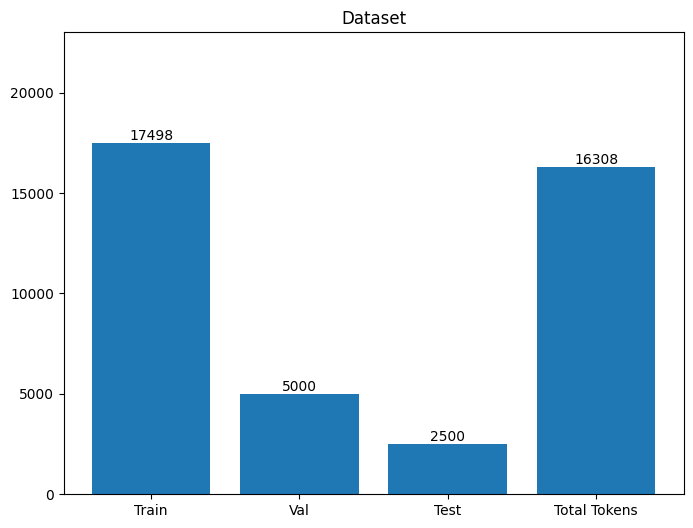

16308

In [ ]:
train = pd.read_csv('/kaggle/input/toxic-comment-dataset/dataset_splited/train.csv')
test = pd.read_csv('/kaggle/input/toxic-comment-dataset/dataset_splited/test.csv')
val = pd.read_csv('/kaggle/input/toxic-comment-dataset/dataset_splited/val.csv')

# bag of word
total_data = list(train['texts'].values) + list(test['texts'].values) + list(val['texts'].values)

tokenizer = get_tokenizer('basic_english')
vocab = []

for sent in total_data:
    sent = unicodedata.normalize('NFKC', sent)
    vocab.extend(tokenizer(sent))

vocab = list(set(vocab))

fig = plt.gcf()
fig.set_size_inches(8, 6)
dataset_len = [len(train), len(val), len(test), len(vocab)]
labels = ['Train', 'Val', 'Test', 'Total Tokens']
position = [1, 2, 3, 4]

plt.bar(position, dataset_len)

for i,j in zip(position, dataset_len):
    if i == 1:
        plt.text(i,j, str(j), ha='center', va='bottom')
    elif i == 4:
        plt.text(i,j, str(j), ha='center', va='bottom')
    else:
        plt.text(i,j, str(j), ha='center', va='bottom')

plt.ylim(0, 23000)
plt.title('Dataset')
plt.xticks(position, labels)
plt.show()
len(vocab)

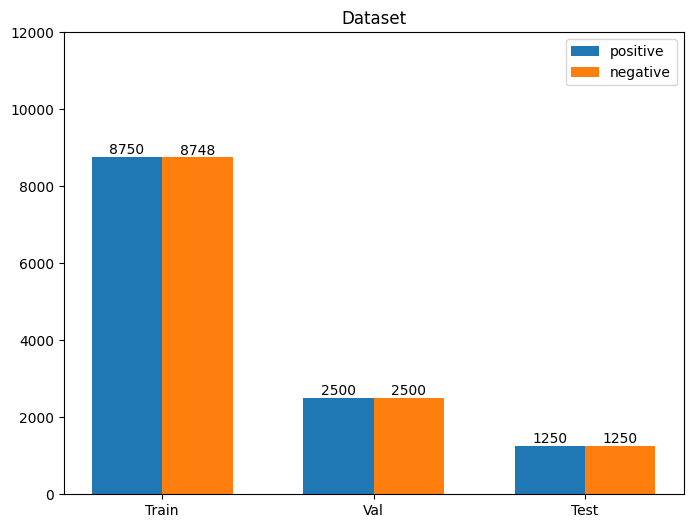

In [ ]:
train = pd.read_csv('/kaggle/input/toxic-comment-dataset/dataset_splited/train.csv')
test = pd.read_csv('/kaggle/input/toxic-comment-dataset/dataset_splited/test.csv')
val = pd.read_csv('/kaggle/input/toxic-comment-dataset/dataset_splited/val.csv')

fig = plt.gcf()
fig.set_size_inches(8, 6)
negative = [len(train[train['labels'] > 0]), len(val[val['labels'] > 0]), len(test[test['labels'] > 0])]
positive = [len(train[train['labels'] < 1]), len(val[val['labels'] < 1]), len(test[test['labels'] < 1])]

labels = ['Train', 'Val', 'Test']
position = np.array([1, 4, 7])

width = 1
plt.bar(position-width/2, positive, width=width, label='positive')
plt.bar(position+width/2, negative, width=width, label='negative')

for i,j in zip(position-width/2, positive):
    plt.text(i,j, str(j), ha='center', va='bottom')

for i,j in zip(position+width/2, negative):
    plt.text(i,j, str(j), ha='center', va='bottom')

plt.ylim(0, 12000)
plt.title('Dataset')
plt.legend()
plt.xticks(position, labels)
plt.show()

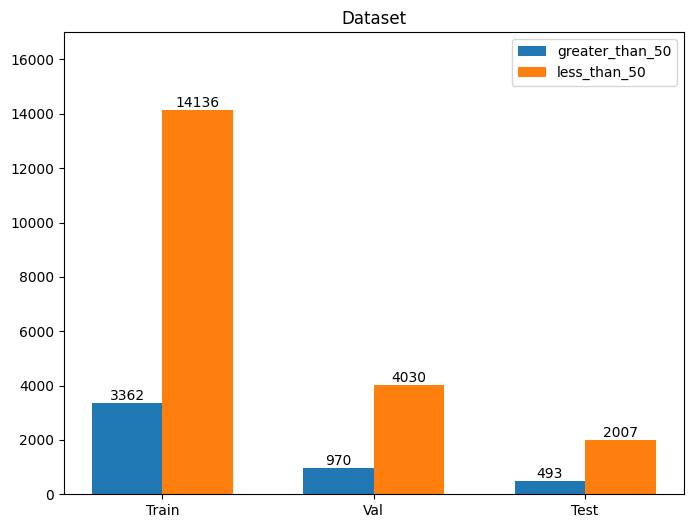

In [ ]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english')

less_than_50_train = 0
greater_than_50_train = 0
for sent in train['texts']:
    if len(tokenizer(sent)) > 50:
        greater_than_50_train+=1
    else:
        less_than_50_train+=1

less_than_50_val = 0
greater_than_50_val = 0
for sent in val['texts']:
    if len(tokenizer(sent)) > 50:
        greater_than_50_val+=1
    else:
        less_than_50_val+=1

less_than_50_test = 0
greater_than_50_test = 0
for sent in test['texts']:
    if len(tokenizer(sent)) > 50:
        greater_than_50_test+=1
    else:
        less_than_50_test+=1

fig = plt.gcf()
fig.set_size_inches(8, 6)
negative = [less_than_50_train, less_than_50_val, less_than_50_test]
positive = [greater_than_50_train, greater_than_50_val, greater_than_50_test]

labels = ['Train', 'Val', 'Test']
position = np.array([1, 4, 7])

width = 1
plt.bar(position-width/2, positive, width=width, label='greater_than_50')
plt.bar(position+width/2, negative, width=width, label='less_than_50')

for i,j in zip(position-width/2, positive):
    plt.text(i,j, str(j), ha='center', va='bottom')

for i,j in zip(position+width/2, negative):
    plt.text(i,j, str(j), ha='center', va='bottom')

plt.ylim(0, 17000)
plt.title('Dataset')
plt.legend()
plt.xticks(position, labels)
plt.show()

## Bag of Word

In [ ]:
# bag of word
# Build Vocabulary
import unicodedata
tokenizer = get_tokenizer('basic_english')
vocab_bag_of_word = []

for sent in list(train['texts'].values):
    sent = unicodedata.normalize("NFKC", sent)
    vocab_bag_of_word.extend(tokenizer(sent))

vocab_bag_of_word = ['oov'] + list(set(vocab_bag_of_word))

vocab_bag_of_word = [unicodedata.normalize("NFKC", word) for word in vocab_bag_of_word]


vocab_bag_of_word = {word:index for index, word in enumerate(vocab_bag_of_word)}

print('len vocab_bag_of_word: ', len(vocab_bag_of_word))


len vocab_bag_of_word:  13775


In [ ]:
vocab_bag_of_word['oov']

0

In [ ]:
# convert text to array
train_texts_bag_of_word = []
for sent in train['texts'].values:
    sent = unicodedata.normalize("NFKC", sent)
    sent_vec = np.zeros(len(vocab_bag_of_word))
    for word in tokenizer(sent):
        sent_vec[vocab_bag_of_word[word]] += 1

    train_texts_bag_of_word.append(sent_vec)

train_texts_bag_of_word = np.array(train_texts_bag_of_word)

In [ ]:
test_texts_bag_of_word = []
for sent in test['texts'].values:
    sent = unicodedata.normalize("NFKC", sent)
    sent_vec = np.zeros(len(vocab_bag_of_word))
    for word in tokenizer(sent):
        if word in list(vocab_bag_of_word.keys()):
            sent_vec[vocab_bag_of_word[word]] += 1
        else:
            sent_vec[vocab_bag_of_word['oov']] += 1

    test_texts_bag_of_word.append(sent_vec)

test_texts_bag_of_word =np.array(test_texts_bag_of_word)

In [ ]:
(train_texts_bag_of_word.shape), (test_texts_bag_of_word.shape)

((17498, 13775), (2500, 13775))

## tf-idf

In [ ]:
# data tf-idf

tokenizer = get_tokenizer('basic_english')
train_texts_tf_idf = []
test_texts_tf_idf = []
for sent in list(train['texts'].values):
    sent = unicodedata.normalize("NFKC", sent)
    train_texts_tf_idf.append(' '.join(tokenizer(sent)))

for sent in list(test['texts'].values):
    sent = unicodedata.normalize("NFKC", sent)
    test_texts_tf_idf.append(' '.join(tokenizer(sent)))



In [ ]:
# fit tf-idf
tf_idf = TfidfVectorizer()
tf_idf.fit(train_texts_tf_idf)

TfidfVectorizer()

In [ ]:
train_texts_tf_idf = tf_idf.transform(train_texts_tf_idf)
test_texts_tf_idf = tf_idf.transform(test_texts_tf_idf)

train_texts_tf_idf.toarray().shape, test_texts_tf_idf.toarray().shape

((17498, 12587), (2500, 12587))

## LogisticRegression

In [ ]:
# bag of word
model = LogisticRegression(C=1.0, solver='lbfgs', max_iter=100)

# Huấn luyện mô hình
model.fit(train_texts_bag_of_word, train['labels'].values)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(test_texts_bag_of_word)

# Đánh giá mô hình
accuracy = accuracy_score(test['labels'].values, y_pred)
conf_matrix = confusion_matrix(test['labels'].values, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Pricision :\n", precision_score(test['labels'].values, y_pred))
print("Recall :\n", recall_score(test['labels'].values, y_pred))

Accuracy: 0.90
Confusion Matrix:
 [[1125  125]
 [ 130 1120]]
Pricision :
 0.8995983935742972
Recall :
 0.896


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


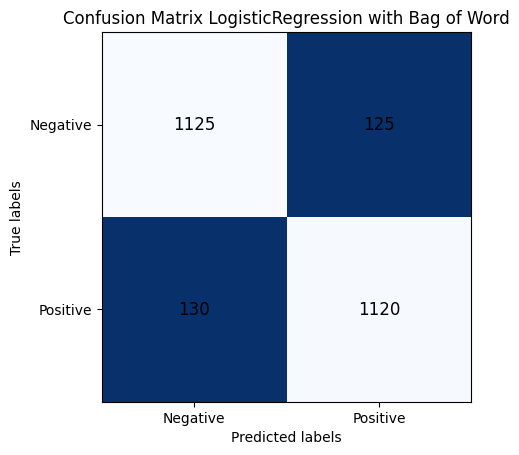

In [ ]:
# plot confusion matrix with bag of word
data = np.array([[1125, 125],
 [ 130, 1120]])


# plot heatmap
plt.imshow(data, cmap=plt.cm.Blues_r, interpolation='nearest')

# Điền giá trị vào từng ô
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.text(j, i, str(data[i, j]), fontsize=12,
                 horizontalalignment='center',
                 verticalalignment='center', color='black')

# Đặt tiêu đề và nhãn trục
plt.title('Confusion Matrix LogisticRegression with Bag of Word')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Đặt ticks cho trục x và trục y
plt.xticks(np.arange(data.shape[1]), ['Negative', 'Positive'])
plt.yticks(np.arange(data.shape[0]), ['Negative', 'Positive'])

plt.show()

In [ ]:
# tf-idf
model = LogisticRegression(C=1.0, solver='lbfgs', max_iter=100)

# Huấn luyện mô hình
model.fit(train_texts_tf_idf, train['labels'].values)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(test_texts_tf_idf)

# Đánh giá mô hình
accuracy = accuracy_score(test['labels'].values, y_pred)
conf_matrix = confusion_matrix(test['labels'].values, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Pricision :\n", precision_score(test['labels'].values, y_pred))
print("Recall :\n", recall_score(test['labels'].values, y_pred))

Accuracy: 0.90
Confusion Matrix:
 [[1118  132]
 [ 126 1124]]
Pricision :
 0.8949044585987261
Recall :
 0.8992


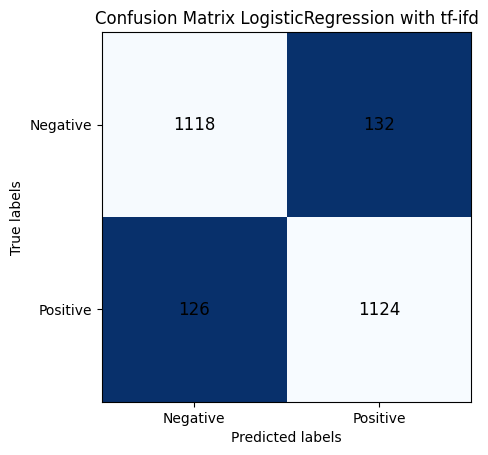

In [ ]:
# plot confusion matrix with tf-idf
data = np.array( [[1118, 132],
 [126, 1124]])


# plot heatmap
plt.imshow(data, cmap=plt.cm.Blues_r, interpolation='nearest')

# Điền giá trị vào từng ô
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.text(j, i, str(data[i, j]), fontsize=12,
                 horizontalalignment='center',
                 verticalalignment='center', color='black')

# Đặt tiêu đề và nhãn trục
plt.title('Confusion Matrix LogisticRegression with tf-ifd')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Đặt ticks cho trục x và trục y
plt.xticks(np.arange(data.shape[1]), ['Negative', 'Positive'])
plt.yticks(np.arange(data.shape[0]), ['Negative', 'Positive'])

plt.show()

## SVM

In [ ]:
# bag of word
model = SVC(C=1.0, kernel='rbf', gamma='scale')

# Huấn luyện mô hình
model.fit(train_texts_bag_of_word, train['labels'].values)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(test_texts_bag_of_word)

# Đánh giá mô hình
accuracy = accuracy_score(test['labels'].values, y_pred)
conf_matrix = confusion_matrix(test['labels'].values, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Pricision :\n", precision_score(test['labels'].values, y_pred))
print("Recall :\n", recall_score(test['labels'].values, y_pred))

Accuracy: 0.90
Confusion Matrix:
 [[1110  140]
 [ 120 1130]]
Pricision :
 0.889763779527559
Recall :
 0.904


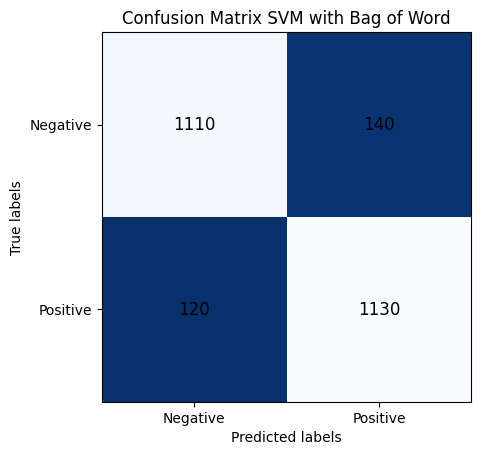

In [ ]:
# plot confusion matrix with bag of word
data = np.array([[1110, 140],
 [120, 1130]])


# plot heatmap
plt.imshow(data, cmap=plt.cm.Blues_r, interpolation='nearest')

# Điền giá trị vào từng ô
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.text(j, i, str(data[i, j]), fontsize=12,
                 horizontalalignment='center',
                 verticalalignment='center', color='black')

# Đặt tiêu đề và nhãn trục
plt.title('Confusion Matrix SVM with Bag of Word')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Đặt ticks cho trục x và trục y
plt.xticks(np.arange(data.shape[1]), ['Negative', 'Positive'])
plt.yticks(np.arange(data.shape[0]), ['Negative', 'Positive'])

plt.show()

In [ ]:
# tf-idf
model = SVC(C=1.0, kernel='rbf', gamma='scale')

# Huấn luyện mô hình
model.fit(train_texts_tf_idf, train['labels'].values)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(test_texts_tf_idf)

# Đánh giá mô hình
accuracy = accuracy_score(test['labels'].values, y_pred)
conf_matrix = confusion_matrix(test['labels'].values, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Pricision :\n", precision_score(test['labels'].values, y_pred))
print("Recall :\n", recall_score(test['labels'].values, y_pred))

Accuracy: 0.90
Confusion Matrix:
 [[1119  131]
 [ 111 1139]]
Pricision :
 0.8968503937007875
Recall :
 0.9112


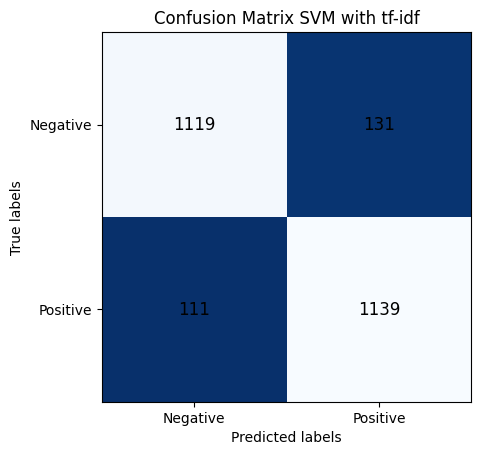

In [ ]:
# plot confusion matrix with tf-idf
data = np.array([[1119, 131],
 [111, 1139]])


# plot heatmap
plt.imshow(data, cmap=plt.cm.Blues_r, interpolation='nearest')

# Điền giá trị vào từng ô
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.text(j, i, str(data[i, j]), fontsize=12,
                 horizontalalignment='center',
                 verticalalignment='center', color='black')

# Đặt tiêu đề và nhãn trục
plt.title('Confusion Matrix SVM with tf-idf')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Đặt ticks cho trục x và trục y
plt.xticks(np.arange(data.shape[1]), ['Negative', 'Positive'])
plt.yticks(np.arange(data.shape[0]), ['Negative', 'Positive'])

plt.show()

## Deep Learning

### Importing the Libraries

In [ ]:
import re
import pandas as pd
import numpy as np
import unicodedata
import pickle
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
from torchtext.data.utils import get_tokenizer
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dropout, Dense, LSTM
from tensorflow.keras import Sequential
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("TensorFlow đang sử dụng GPU:")
    for gpu in gpus:
        print(gpu)
else:
    print("TensorFlow không nhận diện được GPU.")


seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

TensorFlow đang sử dụng GPU:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Load and Handle Dataset

In [ ]:
def text_normalized(sent):
    sent = re.sub(r"(\")", " ", sent)
    sent = re.sub(r" +", " ", sent)
    return sent


In [ ]:
# loading the dataset
train = pd.read_csv('/kaggle/input/toxic-comment-dataset/dataset_splited/train.csv')
test = pd.read_csv('/kaggle/input/toxic-comment-dataset/dataset_splited/test.csv')
val = pd.read_csv('/kaggle/input/toxic-comment-dataset/dataset_splited/val.csv')

train = shuffle(train, random_state=42)
val = shuffle(val, random_state=42)

tokenizer = get_tokenizer('basic_english')

# word token
train_texts = [text_normalized(unicodedata.normalize("NFKC", " ".join(tokenizer(sent)))) for sent in train['texts'].values]
val_texts = [text_normalized(unicodedata.normalize("NFKC", " ".join(tokenizer(sent)))) for sent in val['texts'].values]
test_texts = [text_normalized(unicodedata.normalize("NFKC", " ".join(tokenizer(sent)))) for sent in test['texts'].values]

In [ ]:
# tokenizer
tokenizer = Tokenizer(num_words=30000, oov_token='<OOV>', filters="", split=" ")
tokenizer.fit_on_texts(train_texts)

train_sents = tokenizer.texts_to_sequences(train_texts)
val_sents = tokenizer.texts_to_sequences(val_texts)
test_sents = tokenizer.texts_to_sequences(test_texts)


# padding because max_length of train_texts is 120
max_length = 120
train_sents_padded = pad_sequences(train_sents, padding='post', maxlen=max_length)
val_sents_padded = pad_sequences(val_sents, padding='post', maxlen=max_length)
test_sents_padded = pad_sequences(test_sents, padding='post', maxlen=max_length)

print('max_length:', max_length)

max_length: 120


In [ ]:
train_sents_padded.shape, val_sents_padded.shape, test_sents_padded.shape

((17498, 120), (5000, 120), (2500, 120))

In [ ]:
# vocab size
len_vocab = len(tokenizer.word_index)
len_vocab

13814

In [ ]:
train_sents_padded[:2]

array([[ 678,  652,   37,   14,    6,   58,  308, 1533,  558,   16,  744,
        3011,  995, 1533,  558,  115,   37,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 309,  436,   13,   15,    2,  382, 1006,  143,   25,  536,  233,
         343,    2,   46,  488,  424,    2,  218,  586,   73,    8,  338,
         611,    3,   19,  202,   20,  117,

In [ ]:
y_train = np.array(train['labels'].values)
y_val = np.array(val['labels'].values)
y_test = np.array(test['labels'].values)

y_train.shape, y_val.shape, y_test.shape

((17498,), (5000,), (2500,))

In [ ]:
print('vocab size:', len(tokenizer.index_word))
len_vocab = len(tokenizer.index_word)

vocab size: 13814


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sents_padded, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sents_padded, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sents_padded, y_test))

# Shuffle và chia thành batches
batch_size = 250
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1000).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1000).batch(batch_size)

In [ ]:
# Tạo một iterator để lặp qua các batch
for batch_x, batch_y in train_dataset.take(1):  # Lấy 1 batch
    print("Batch X shape:", batch_x.shape)
    print("Batch y shape:", batch_y)

Batch X shape: (250, 120)
Batch y shape: tf.Tensor(
[0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1
 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1
 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 0
 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1 0 0 1
 0 0 1 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0
 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0], shape=(250,), dtype=int64)


## Tensorflow

## Simple RNN

In [ ]:
embed_output = 100
hidden_state = 100

RNN = tf.keras.Sequential([
    Embedding(input_dim=len_vocab, output_dim=embed_output, input_length=max_length),
    SimpleRNN(hidden_state),
    Dense(1, activation='sigmoid')
    ])

RNN.compile(optimizer='adam',
          loss='binary_crossentropy',
          metrics=['accuracy', 'precision', 'recall'])

RNN.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint = ModelCheckpoint('/kaggle/working/simpleRNN_e100_h100.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1)

history = RNN.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[early_stopping, checkpoint])

with open('/kaggle/working/simpleRNN_e100_h100.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5289 - loss: 0.6898 - precision: 0.5268 - recall: 0.5159
Epoch 1: val_loss improved from inf to 0.63388, saving model to /kaggle/working/simpleRNN_e100_h100.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5294 - loss: 0.6896 - precision: 0.5274 - recall: 0.5162 - val_accuracy: 0.6490 - val_loss: 0.6339 - val_precision: 0.7356 - val_recall: 0.4652
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6836 - loss: 0.6057 - precision: 0.7581 - recall: 0.5315
Epoch 2: val_loss improved from 0.63388 to 0.59245, saving model to /kaggle/working/simpleRNN_e100_h100.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6839 - loss: 0.6055 - precision: 0.7583 - recall: 0.5321 - val_accuracy: 0.7038 - val_loss: 0.5925 - val_precision: 0.7323 - val_recall: 0.6424
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7583 - loss: 0.5226 - precision: 0.8108 - recall: 0.6718
Epoch 3: val_loss i

In [ ]:
model = tf.keras.models.load_model("/kaggle/working/simpleRNN_e100_h100.keras")

[round(num, 3)for num in model.evaluate(test_dataset, steps=2500)]

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 25us/step - accuracy: 0.7146 - loss: 0.5858 - precision: 0.7835 - recall: 0.5910 


[0.586, 0.714, 0.785, 0.591]

In [ ]:
model = tf.keras.models.load_model("/kaggle/input/toxic-comment-model/model/simpleRNN_e100_h100.keras")
pre_labels = []
from tqdm import tqdm
data = tqdm(test_sents_padded, total=len(test_sents_padded))
for sent in data:
    pred = model.predict(np.array(sent).reshape(1, -1),  verbose=0)
    pre_labels.append(int(np.round(pred[0,0])))


pre_labels = np.array(pre_labels).reshape(-1, 1)

100%|██████████| 2500/2500 [02:16<00:00, 18.30it/s]


In [ ]:
y_test = np.array(y_test).reshape(-1, 1)
pre_labels = np.array(pre_labels).reshape(-1, 1)
y_test.shape, pre_labels.shape

((2500, 1), (2500, 1))

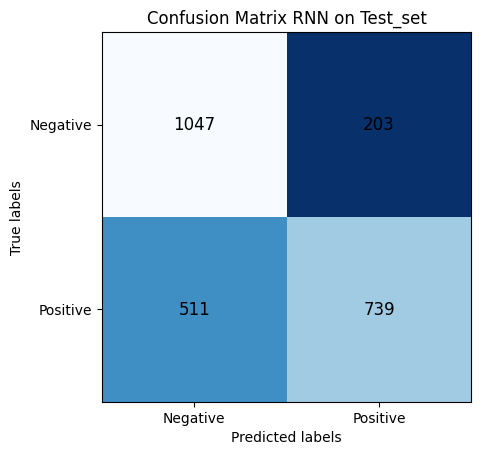

In [ ]:
# plot confusion matrix with bag of word
data = np.array(confusion_matrix(y_test, pre_labels))


# plot heatmap
plt.imshow(data, cmap=plt.cm.Blues_r, interpolation='nearest')

# Điền giá trị vào từng ô
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.text(j, i, str(data[i, j]), fontsize=12,
                 horizontalalignment='center',
                 verticalalignment='center', color='black')

# Đặt tiêu đề và nhãn trục
plt.title('Confusion Matrix RNN on Test_set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Đặt ticks cho trục x và trục y
plt.xticks(np.arange(data.shape[1]), ['Negative', 'Positive'])
plt.yticks(np.arange(data.shape[0]), ['Negative', 'Positive'])

plt.show()

## Bidirectional RNN

In [ ]:
max_length

120

In [ ]:
embed_output = 100
hidden_state = 100

BiRNN=Sequential([Embedding(input_dim = len_vocab, output_dim = embed_output, input_length = max_length),
                 Bidirectional(SimpleRNN(hidden_state)),
                 Dense(1, activation='sigmoid')])

BiRNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])
BiRNN.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint = ModelCheckpoint('/kaggle/working/BiRNN_e100_h100.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1)

history = BiRNN.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[early_stopping, checkpoint])

with open('/kaggle/working/BiRNN_e100_h100.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6119 - loss: 0.6334 - precision: 0.6134 - recall: 0.5988
Epoch 1: val_loss improved from inf to 0.34056, saving model to /kaggle/working/BiRNN_e100_h100.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.6133 - loss: 0.6321 - precision: 0.6149 - recall: 0.6001 - val_accuracy: 0.8618 - val_loss: 0.3406 - val_precision: 0.8838 - val_recall: 0.8332
Epoch 2/100
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8937 - loss: 0.2700 - precision: 0.8886 - recall: 0.8986
Epoch 2: val_loss improved from 0.34056 to 0.28262, saving model to /kaggle/working/BiRNN_e100_h100.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8940 - loss: 0.2694 - precision: 0.8889 - recall: 0.8990 - val_accuracy: 0.8908 - val_loss: 0.2826 - val_precision: 0.8720 - val_recall: 0.9160
Epoch 3/100
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9475 - loss: 0.1480 - precision: 0.9440 - recall: 0.9507
Epoch 3: val_loss did not i

In [ ]:
model = tf.keras.models.load_model("/kaggle/working/BiRNN_e100_h100.keras")
[round(num, 3)for num in model.evaluate(test_dataset, steps=4999)]

4999/4999 ━━━━━━━━━━━━━━━━━━━━ 1s 20us/step - accuracy: 0.8872 - loss: 0.2995 - precision: 0.8651 - recall: 0.9166 


[0.299, 0.887, 0.866, 0.917]

In [ ]:
model = tf.keras.models.load_model("/kaggle/input/toxic-comment-model/model/BiRNN_e100_h100.keras")
pre_labels = []
from tqdm import tqdm
data = tqdm(test_sents_padded, total=len(test_sents_padded))
for sent in data:
    pred = model.predict(np.array(sent).reshape(1, -1),  verbose=0)
    pre_labels.append(int(np.round(pred[0,0])))


pre_labels = np.array(pre_labels).reshape(-1, 1)

100%|██████████| 2500/2500 [02:22<00:00, 17.59it/s]


In [ ]:
accuracy = accuracy_score(y_test, pre_labels)
conf_matrix = confusion_matrix(y_test, pre_labels)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Pricision :\n", precision_score(y_test, pre_labels))
print("Recall :\n", recall_score(y_test, pre_labels))

Accuracy: 0.89
Confusion Matrix:
 [[1072  178]
 [ 104 1146]]
Pricision :
 0.8655589123867069
Recall :
 0.9168


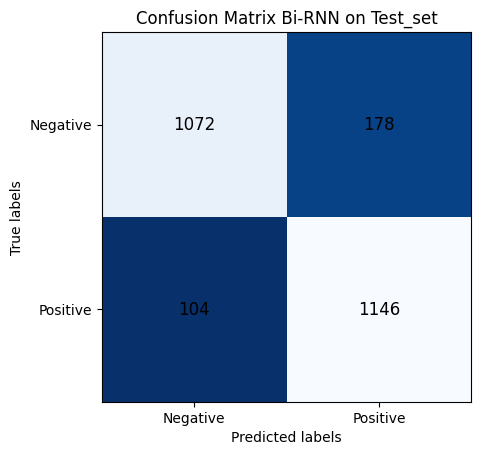

In [ ]:
# plot confusion matrix with bag of word
data = np.array(confusion_matrix(y_test, pre_labels))


# plot heatmap
plt.imshow(data, cmap=plt.cm.Blues_r, interpolation='nearest')

# Điền giá trị vào từng ô
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.text(j, i, str(data[i, j]), fontsize=12,
                 horizontalalignment='center',
                 verticalalignment='center', color='black')

# Đặt tiêu đề và nhãn trục
plt.title('Confusion Matrix Bi-RNN on Test_set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Đặt ticks cho trục x và trục y
plt.xticks(np.arange(data.shape[1]), ['Negative', 'Positive'])
plt.yticks(np.arange(data.shape[0]), ['Negative', 'Positive'])

plt.show()

## LSTM

In [ ]:
embed_output = 50
hidden_state = 50

lstm = tf.keras.Sequential([
    Embedding(input_dim=len_vocab, output_dim=embed_output, input_length=max_length),
    LSTM(hidden_state),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

lstm.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint = ModelCheckpoint('/kaggle/working/lstm_e50_h50.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1)

history = lstm.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[early_stopping, checkpoint])

with open('/kaggle/working/lstm_e50_h50.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/100
67/70 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5071 - loss: 0.6934 - precision: 0.4367 - recall: 0.3826
Epoch 1: val_loss improved from inf to 0.69364, saving model to /kaggle/working/lstm_e50_h50.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5069 - loss: 0.6934 - precision: 0.4405 - recall: 0.3867 - val_accuracy: 0.5000 - val_loss: 0.6936 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/100
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4971 - loss: 0.6934 - precision: 0.4928 - recall: 0.4514
Epoch 2: val_loss improved from 0.69364 to 0.69328, saving model to /kaggle/working/lstm_e50_h50.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4971 - loss: 0.6934 - precision: 0.4929 - recall: 0.4467 - val_accuracy: 0.5000 - val_loss: 0.6933 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5000 - loss: 0.6932 - precision: 0.4988 - recall: 0.6964
Epoch 3: val_loss improved from 0

In [ ]:
model = tf.keras.models.load_model("/kaggle/working/lstm_e50_h50.keras")
[round(num, 3)for num in model.evaluate(test_dataset, steps=2500)]

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 35us/step - accuracy: 0.6445 - loss: 0.6475 - precision: 0.6130 - recall: 0.7796           


[0.647, 0.645, 0.614, 0.78]

In [ ]:
model = tf.keras.models.load_model("/kaggle/input/toxic-comment-model/model/lstm_e50_h50.keras")
pre_labels = []
from tqdm import tqdm
data = tqdm(test_sents_padded, total=len(test_sents_padded))
for sent in data:
    pred = model.predict(np.array(sent).reshape(1, -1),  verbose=0)
    pre_labels.append(int(np.round(pred[0,0])))


pre_labels = np.array(pre_labels).reshape(-1, 1)

100%|██████████| 2500/2500 [02:22<00:00, 17.60it/s]


In [ ]:
accuracy = accuracy_score(y_test, pre_labels)
conf_matrix = confusion_matrix(y_test, pre_labels)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Pricision :\n", precision_score(y_test, pre_labels))
print("Recall :\n", recall_score(y_test, pre_labels))

Accuracy: 0.64
Confusion Matrix:
 [[637 613]
 [275 975]]
Pricision :
 0.6139798488664987
Recall :
 0.78


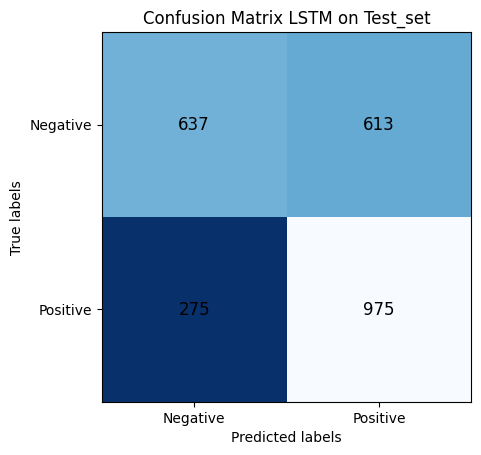

In [ ]:
# plot confusion matrix with bag of word
data = np.array(confusion_matrix(y_test, pre_labels))

# plot heatmap
plt.imshow(data, cmap=plt.cm.Blues_r, interpolation='nearest')

# Điền giá trị vào từng ô
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.text(j, i, str(data[i, j]), fontsize=12,
                 horizontalalignment='center',
                 verticalalignment='center', color='black')

# Đặt tiêu đề và nhãn trục
plt.title('Confusion Matrix LSTM on Test_set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Đặt ticks cho trục x và trục y
plt.xticks(np.arange(data.shape[1]), ['Negative', 'Positive'])
plt.yticks(np.arange(data.shape[0]), ['Negative', 'Positive'])

plt.show()

## Bidirectional LSTM

In [ ]:
embed_output = 100
hidden_state = 100

BiLSTM=Sequential([Embedding(input_dim = len_vocab, output_dim = embed_output, input_length = max_length),
                 Bidirectional(LSTM(hidden_state)),
                 Dense(1, activation='sigmoid')])

BiLSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])
BiLSTM.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint = ModelCheckpoint('/kaggle/working/BiLSTM_e100_h100.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1)

history = BiLSTM.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[early_stopping, checkpoint])

with open('/kaggle/working/BiLSTM_e100_h100.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/100
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6667 - loss: 0.6398 - precision: 0.6755 - recall: 0.6380
Epoch 1: val_loss improved from inf to 0.34226, saving model to /kaggle/working/BiLSTM_e100_h100.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6690 - loss: 0.6369 - precision: 0.6779 - recall: 0.6403 - val_accuracy: 0.8564 - val_loss: 0.3423 - val_precision: 0.8362 - val_recall: 0.8864
Epoch 2/100
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8912 - loss: 0.2773 - precision: 0.8872 - recall: 0.8939
Epoch 2: val_loss improved from 0.34226 to 0.24073, saving model to /kaggle/working/BiLSTM_e100_h100.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8916 - loss: 0.2765 - precision: 0.8874 - recall: 0.8945 - val_accuracy: 0.9054 - val_loss: 0.2407 - val_precision: 0.8820 - val_recall: 0.9360
Epoch 3/100
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9286 - loss: 0.1885 - precision: 0.9174 - recall: 0.9412
Epoch 3: val_loss improve

In [ ]:
model = tf.keras.models.load_model("/kaggle/working/BiLSTM_e100_h100.keras")
[round(num, 3)for num in model.evaluate(test_dataset, steps=2500)]

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 60us/step - accuracy: 0.9063 - loss: 0.2464 - precision: 0.8765 - recall: 0.9444  


[0.246, 0.906, 0.877, 0.945]

In [ ]:
model = tf.keras.models.load_model("/kaggle/input/toxic-comment-model/model/BiLSTM_e100_h100.keras")
pre_labels = []
from tqdm import tqdm
data = tqdm(test_sents_padded, total=len(test_sents_padded))
for sent in data:
    pred = model.predict(np.array(sent).reshape(1, -1),  verbose=0)
    pre_labels.append(int(np.round(pred[0,0])))


pre_labels = np.array(pre_labels).reshape(-1, 1)

100%|██████████| 2500/2500 [02:22<00:00, 17.51it/s]


In [ ]:
accuracy = accuracy_score(y_test, pre_labels)
conf_matrix = confusion_matrix(y_test, pre_labels)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Pricision :\n", precision_score(y_test, pre_labels))
print("Recall :\n", recall_score(y_test, pre_labels))

Accuracy: 0.91
Confusion Matrix:
 [[1085  165]
 [  69 1181]]
Pricision :
 0.8774145616641902
Recall :
 0.9448


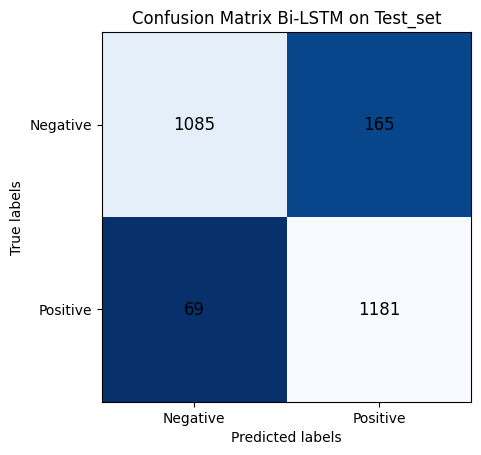

In [ ]:
# plot confusion matrix with bag of word
data = np.array(confusion_matrix(y_test, pre_labels))


# plot heatmap
plt.imshow(data, cmap=plt.cm.Blues_r, interpolation='nearest')

# Điền giá trị vào từng ô
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.text(j, i, str(data[i, j]), fontsize=12,
                 horizontalalignment='center',
                 verticalalignment='center', color='black')

# Đặt tiêu đề và nhãn trục
plt.title('Confusion Matrix Bi-LSTM on Test_set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Đặt ticks cho trục x và trục y
plt.xticks(np.arange(data.shape[1]), ['Negative', 'Positive'])
plt.yticks(np.arange(data.shape[0]), ['Negative', 'Positive'])

plt.show()

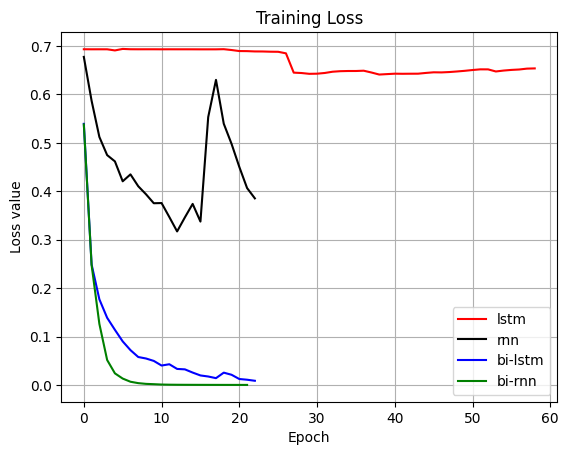

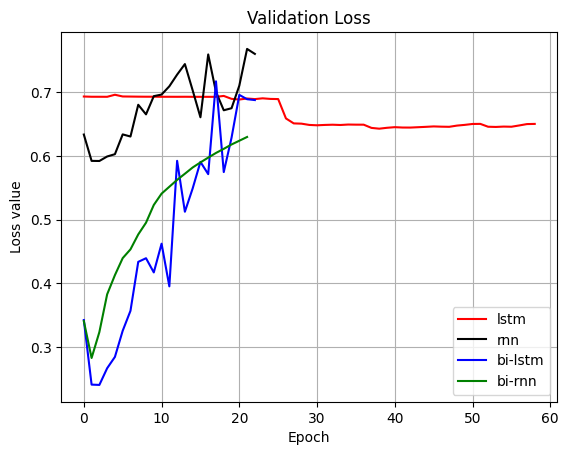

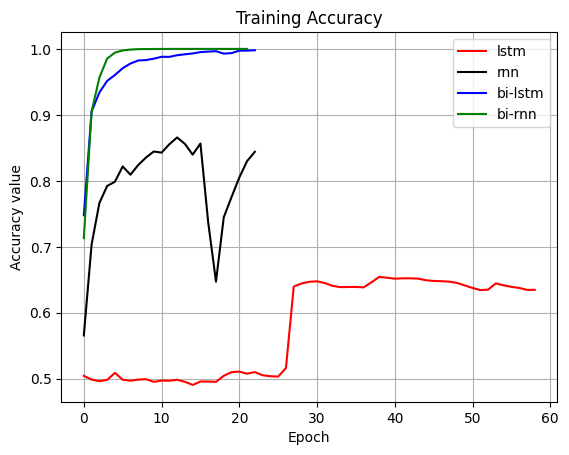

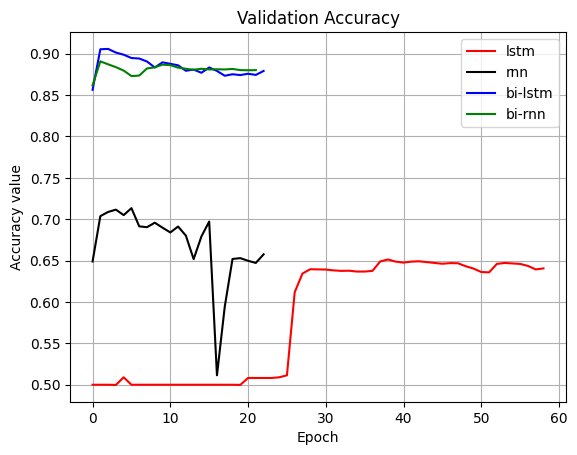

In [ ]:
import pickle as pkl
import numpy as np

with open("/kaggle/input/toxic-comment-model/model/BiLSTM_e100_h100.pkl", "rb") as file:
    bi_lstm = pkl.load(file)

with open("/kaggle/input/toxic-comment-model/model/BiRNN_e100_h100.pkl", "rb") as file:
    bi_rnn = pkl.load(file)

with open("/kaggle/input/toxic-comment-model/model/lstm_e50_h50.pkl", "rb") as file:
    lstm = pkl.load(file)

with open("/kaggle/input/toxic-comment-model/model/simpleRNN_e100_h100.pkl", "rb") as file:
    rnn = pkl.load(file)

lstm_loss = lstm['loss']
lstm_val_loss = lstm['val_loss']
lstm_acc = lstm['accuracy']
lstm_val_acc = lstm['val_accuracy']
lstm_epoch = np.arange(len(lstm_acc))

rnn_loss = rnn['loss']
rnn_val_loss = rnn['val_loss']
rnn_acc = rnn['accuracy']
rnn_val_acc = rnn['val_accuracy']
rnn_epoch = np.arange(len(rnn_acc))

bi_lstm_loss = bi_lstm['loss']
bi_lstm_val_loss = bi_lstm['val_loss']
bi_lstm_acc = bi_lstm['accuracy']
bi_lstm_val_acc = bi_lstm['val_accuracy']
bi_lstm_epoch = np.arange(len(bi_lstm_acc))

bi_rnn_loss = bi_rnn['loss']
bi_rnn_val_loss = bi_rnn['val_loss']
bi_rnn_acc = bi_rnn['accuracy']
bi_rnn_val_acc = bi_rnn['val_accuracy']
bi_rnn_epoch = np.arange(len(bi_rnn_acc))

plt.plot(lstm_epoch, lstm_loss, 'r', label='lstm')
plt.plot(rnn_epoch, rnn_loss, 'black', label='rnn')
plt.plot(bi_lstm_epoch, bi_lstm_loss, 'blue', label='bi-lstm')
plt.plot(bi_rnn_epoch, bi_rnn_loss, 'green', label='bi-rnn')

plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()
plt.grid()
plt.show()

plt.plot(lstm_epoch, lstm_val_loss, 'r', label='lstm')
plt.plot(rnn_epoch, rnn_val_loss, 'black', label='rnn')
plt.plot(bi_lstm_epoch, bi_lstm_val_loss, 'blue', label='bi-lstm')
plt.plot(bi_rnn_epoch, bi_rnn_val_loss, 'green', label='bi-rnn')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()
plt.grid()
plt.show()

plt.plot(lstm_epoch, lstm_acc, 'r', label='lstm')
plt.plot(rnn_epoch, rnn_acc, 'black', label='rnn')
plt.plot(bi_lstm_epoch, bi_lstm_acc, 'blue', label='bi-lstm')
plt.plot(bi_rnn_epoch, bi_rnn_acc, 'green', label='bi-rnn')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy value')
plt.legend()
plt.grid()
plt.show()

plt.plot(lstm_epoch, lstm_val_acc, 'r', label='lstm')
plt.plot(rnn_epoch, rnn_val_acc, 'black', label='rnn')
plt.plot(bi_lstm_epoch, bi_lstm_val_acc, 'blue', label='bi-lstm')
plt.plot(bi_rnn_epoch, bi_rnn_val_acc, 'green', label='bi-rnn')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy value')
plt.legend()
plt.grid()
plt.show()